In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd

In [4]:
import celloracle as co

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
# base_GRN

In [6]:
import anndata
adata = anndata.read_h5ad('../data/slideseq/day3_2.h5ad')
adata.layers["raw_count"] = adata.X
adata

AnnData object with n_obs × n_vars = 13744 × 25343
    obs: 'cluster', 'rctd_cluster'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'raw_count'

In [70]:
n_top_genes = 3000 
min_cells = 10 #Minimum number of cells expressed required for a gene to pass filtering.
min_counts = 300 #Minimum number of counts required for a cell to pass filtering.
gene_min_counts = None #Minimum number of counts required for a gene to pass filtering.

adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
sc.pp.filter_cells(adata, min_counts=min_counts)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
adata = adata[:, ~adata.var["mt"]]
sc.pp.filter_genes(adata, min_cells=min_cells, min_counts=gene_min_counts)

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata, flavor="seurat", n_top_genes=n_top_genes)

adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 12006 × 3000
    obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'raw_count'

In [71]:
'Pax5' in adata.var_names

True

In [72]:
%%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')

CPU times: user 5.58 s, sys: 2.35 s, total: 7.93 s
Wall time: 5.1 s


In [73]:
sc.tl.paga(adata, groups='rctd_cluster')

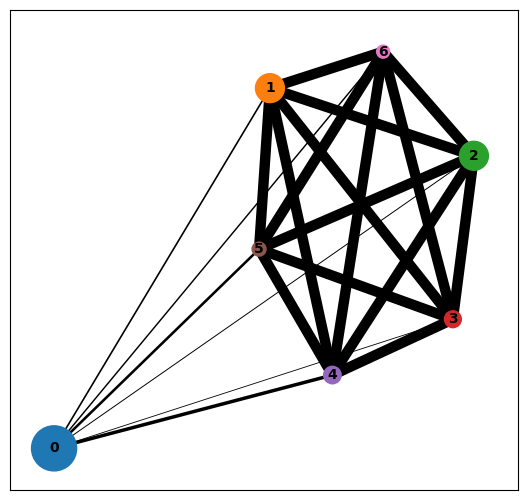

In [74]:
plt.rcParams["figure.figsize"] = [6, 6]
sc.pl.paga(adata)

In [75]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)

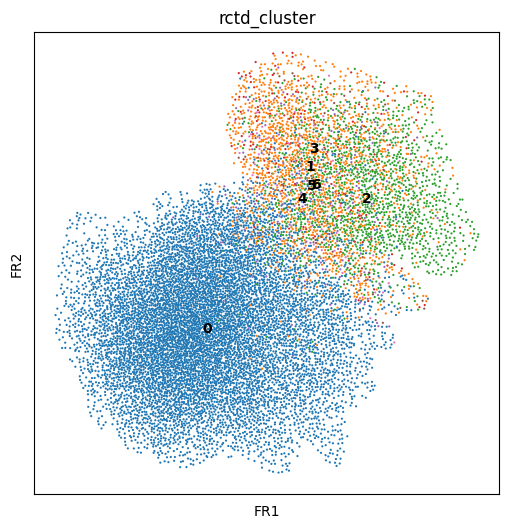

In [76]:
%matplotlib inline
sc.pl.draw_graph(adata, color='rctd_cluster', legend_loc='on data')

In [77]:
oracle = co.Oracle()

In [78]:
adata.layers["raw_count"].toarray().sum(0)

array([835.,  17.,  34., ...,  75., 508., 553.], dtype=float32)

In [79]:
adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="rctd_cluster",
    embedding_name="X_draw_graph_fr"
)

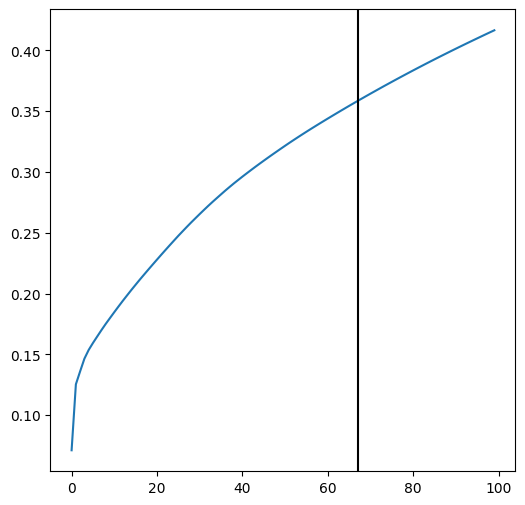

67


In [80]:
%matplotlib inline

# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [128]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :12006


In [82]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :300


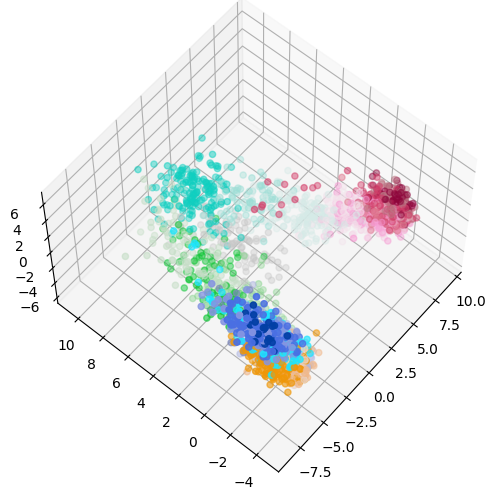

In [172]:
oracle.plot_pca()

In [170]:
oracle.knn_imputation?

Signature:
oracle.knn_imputation(
    k: int = None,
    metric: str = 'euclidean',
    diag: float = 1,
    n_pca_dims: int = None,
    maximum: bool = False,
    balanced: bool = False,
    b_sight: int = None,
    b_maxl: int = None,
    group_constraint: Union[str, numpy.ndarray] = None,
    n_jobs: int = 8,
) -> None
Docstring:
Performs k-nn smoothing of the data matrix

Arguments
---------
k: int
    number of neighbors. If None the default it is chosen to be `0.025 * Ncells`
metric: str
    "euclidean" or "correlation"
diag: int, default=1
    before smoothing this value is substituted in the diagonal of the knn contiguity matrix
    Resulting in a reduction of the smoothing effect.
    E.g. if diag=8 and k=10 value of Si = (8 * S_i + sum(S_n, with n in 5nn of i)) / (8+5)
maximum: bool, default=False
    If True the maximum value of the smoothing and the original matrix entry is taken.
n_pca_dims: int, default=None
    number of pca to use for the knn distance metric. If None al

In [83]:
oracle.knn_imputation(
    n_pca_dims=n_comps, 
    k=k, 
    balanced=True, 
    b_sight=k*8,
    b_maxl=k*4, 
    n_jobs=4
)

In [84]:
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [168]:
adata.obsm['X_pca'].shape

(12006, 50)

In [131]:
adata.obs['rctd_cluster'].value_counts()

rctd_cluster
0    8600
2    1458
1    1448
4     194
3     168
5      79
6      59
Name: count, dtype: int64

In [132]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="rctd_cluster", 
    alpha=10,
    verbose_level=10
)

  0%|          | 0/7 [00:00<?, ?it/s]

Inferring GRN for 0...


  0%|          | 0/2327 [00:00<?, ?it/s]

Akr1c13 (20, 18)
Pygl (20, 20)
Itgax (20, 7)
Kcnj15 (20, 19)
Adm (20, 37)
Fgfr3 (20, 50)
Brpf1 (20, 65)
Slc19a1 (20, 30)
Mlh1 (20, 13)
Nfasc (20, 57)
Snta1 (20, 21)


  0%|          | 0/7 [00:01<?, ?it/s]

L1cam (20, 38)


KeyboardInterrupt: 

In [86]:
import pickle

with open('../data/slideseq/celloracle_links_day3_2.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

In [88]:
links.links_dict[0][links.links_dict[0].p < 0.05].query('target=="Cd74"').reset_index(drop=True).sort_values(by='coef_mean', ascending=False)

,source,target,coef_mean,coef_abs,p,-logp
4,Pax5,Cd74,0.161919,0.161919,2.714144e-12,11.566367
8,Bcl11a,Cd74,0.155490,0.155490,4.487749e-10,9.347971
9,Ebf1,Cd74,0.152978,0.152978,1.918476e-11,10.717044
2,Hivep1,Cd74,0.040176,0.040176,1.695605e-17,16.770675
12,Atf5,Cd74,0.029678,0.029678,9.966940e-14,13.001438
13,Stat2,Cd74,0.029608,0.029608,1.920086e-08,7.716679
3,Mef2c,Cd74,0.028443,0.028443,4.334567e-07,6.363054
1,Etv5,Cd74,0.021734,0.021734,7.640477e-14,13.116880
11,Ebf3,Cd74,-0.004162,0.004162,1.597110e-09,8.796665
10,Klf12,Cd74,-0.007305,0.007305,1.495652e-05,4.825170


In [30]:
links.links_dict[0].query('target=="Cd74"')

,source,target,coef_mean,coef_abs,p,-logp
12260,Sp4,Cd74,0.012732,0.012732,6.596407e-07,6.180693
12261,Prdm9,Cd74,0.040005,0.040005,1.005524e-12,11.997608
12262,Foxk2,Cd74,-0.010438,0.010438,3.809759e-04,3.419103
12263,Rel,Cd74,0.095214,0.095214,6.503320e-11,10.186865
12264,Stat2,Cd74,0.128274,0.128274,3.810128e-11,10.419060
12265,Egr2,Cd74,-0.064275,0.064275,1.998036e-10,9.699397
12266,Gabpa,Cd74,-0.020096,0.020096,1.581749e-04,3.800862
12267,Atf3,Cd74,0.002001,0.002001,1.481664e-01,0.829250
12268,Klf8,Cd74,-0.004975,0.004975,7.793726e-04,3.108255
12269,Ebf1,Cd74,0.221370,0.221370,2.381974e-18,17.623063


In [90]:
import pickle

with open('/Users/koush/Projects/SpaceOracle/data/slideseq/celloracle_links_day3_1.pkl', 'rb') as f:
    links_day3_1 = pickle.load(f)

with open('/Users/koush/Projects/SpaceOracle/data/slideseq/celloracle_links_day3_2.pkl', 'rb') as f:
    links_day3_2 = pickle.load(f)

In [123]:
regulators = pd.concat(
    [list(links_day3_1.values())[x].query('target=="Cd74" and p < 0.05')[['source', 'coef_mean']] 
        for x in range(len(links_day3_1))], axis=0)

In [127]:
(regulators
    .groupby('source')
    .mean()
    .sort_values(by='coef_mean', ascending=False)).index.tolist()

['Pax5',
 'Mef2c',
 'Bcl11a',
 'Ebf1',
 'Pou2f2',
 'Irf9',
 'Tbp',
 'Stat2',
 'Tal1',
 'Myc',
 'Rreb1',
 'Ebf3',
 'Rxra',
 'Foxj3',
 'Taf1',
 'Tcf7l2',
 'Hivep1',
 'Atf3',
 'Klf7',
 'Zkscan1',
 'Gata2',
 'Mef2a',
 'Egr2',
 'Egr1']

<AxesSubplot: xlabel='source'>

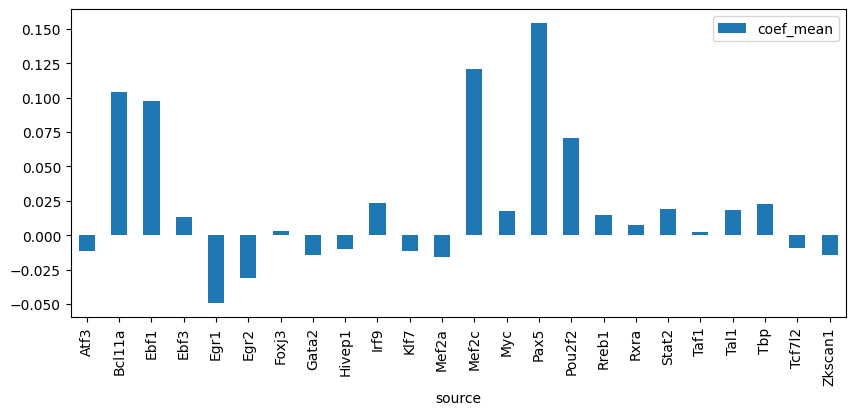

In [120]:
plt.rcParams["figure.figsize"] = [10, 4]
df.groupby('source').mean().plot(kind='bar')

In [34]:
pd.DataFrame(
    [df2.set_index('target').loc[np.intersect1d(
        df1.target, df2.target)].coef_mean-df1.set_index('target').loc[
     np.intersect1d(df1.target, df2.target)].coef_mean]).T.sort_values(by='coef_mean', ascending=False)[:20]

,coef_mean
target,
Ccl5,0.031504
Rps24,0.027042
Lgals1,0.024633
Cd74,0.023614
Iglc3,0.018855
Smc4,0.015679
Epsti1,0.015348
Lyz2,0.014656
Clu,0.011830


In [7]:
oracle = co.data.load_tutorial_oracle_object()

/Users/koush/Projects/SpaceOracle/notebooks/../src/celloracle/utility/hdf5_processing.py:41: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  return pickle.loads(zlib.decompress(uint.tobytes()))
/Users/koush/Projects/SpaceOracle/notebooks/../src/celloracle/utility/hdf5_processing.py:41: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  return pickle.loads(zlib.decompress(uint.tobytes()))
/Users/koush/Projects/SpaceOracle/notebooks/../src/celloracle/utility/hdf5_processing.py:41: DeprecationWarning: Please import `coo_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.coo` namespace is deprecated and will be removed in SciPy 2.0.0.
  return pickle.loads(zlib.decompress(uint.tobytes()))


In [20]:
oracle.adata.obs['paul15_clusters'].unique()

['7MEP', '15Mo', '3Ery', '4Ery', '2Ery', ..., '6Ery', '12Baso', '18Eos', '11DC', '19Lymph']
Length: 19
Categories (19, object): ['1Ery', '2Ery', '3Ery', '4Ery', ..., '16Neu', '17Neu', '18Eos', '19Lymph']

In [28]:
oracle.adata

AnnData object with n_obs × n_vars = 2671 × 1999
    obs: 'paul15_clusters', 'n_counts_all', 'n_counts', 'louvain', 'cell_type', 'louvain_annot', 'Lineage_MEP', 'Lineage_GMP', 'Pseudotime_Lineage_MEP', 'Pseudotime_Lineage_GMP', 'Pseudotime'
    var: 'n_counts', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators'
    uns: 'cell_type_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'louvain', 'louvain_annot_colors', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'paul15_clusters_colors', 'pca', 'log1p'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca'
    varm: 'PCs'
    layers: 'raw_count', 'normalized_count', 'imputed_count', 'simulation_input'
    obsp: 'connectivities', 'distances'

In [33]:
mat = pd.read_csv("coef_matrix.csv", index_col=0)

In [40]:
# oracle.TFdict

In [44]:
np.intersect1d(mat.columns, list(oracle.TFdict.keys())).__len__()

1850

In [45]:
np.intersect1d(mat.columns, list(oracle.TFdict.keys()))

array(['0610007L01Rik', '0610010K14Rik', '0910001L09Rik', ..., 'Zmynd11',
       'Zswim4', 'Zyx'], dtype=object)

In [47]:
mat['Zyx'][mat['Zyx'] > 0]

Chd2     0.061002
Elf1     0.001180
Ets1     0.008602
Fli1     0.030356
Id2      0.007249
Klf6     0.019745
Mef2c    0.027569
Mycn     0.009732
Nfe2     0.138767
Nfkb1    0.040420
Rel      0.002212
Stat3    0.066046
Zbtb4    0.000165
Name: Zyx, dtype: float64

In [50]:
np.intersect1d(mat.columns, oracle.TFdict['Zyx'])

array(['Batf3', 'Chd2', 'Cxxc1', 'E2f4', 'Egr1', 'Elf1', 'Ets1', 'Fli1',
       'Hnf4a', 'Id2', 'Irf1', 'Klf1', 'Klf2', 'Klf4', 'Klf6', 'Mef2c',
       'Myc', 'Mycn', 'Nfe2', 'Nfia', 'Nfic', 'Nfkb1', 'Nr3c1', 'Prdm5',
       'Rel', 'Rreb1', 'Smarca5', 'Smarcc1', 'Smarcc2', 'Stat1', 'Stat3',
       'Stat5a', 'Zbtb1', 'Zbtb4', 'Zbtb7a'], dtype=object)

In [52]:
np.intersect1d(oracle.adata.var_names, oracle.TFdict['0610007L01Rik'])

array(['Chd2', 'E2f4', 'Egr1', 'Elf1', 'Ets1', 'Fli1', 'Foxp1', 'Gata1',
       'Gata2', 'Hnf4a', 'Id2', 'Irf7', 'Klf2', 'Klf6', 'Mef2c', 'Myc',
       'Mycn', 'Nfe2', 'Nfkb1', 'Rara', 'Runx1', 'Stat1', 'Stat3',
       'Stat4', 'Stat5a', 'Zbtb1', 'Zbtb7a'], dtype=object)

In [51]:
oracle.fit_GRN_for_simulation()

  0%|          | 0/24 [00:00<?, ?it/s]

['Hnf4a', 'Stat1', 'Mef2c', 'Elf1', 'Id2', 'Mycn', 'Zbtb7a', 'Rara', 'Klf6', 'Fli1', 'Runx1', 'Zbtb1', 'Nfe2', 'Gata1', 'Nfkb1', 'Irf7', 'Ets1', 'Stat4', 'Gata2', 'E2f4', 'Foxp1', 'Chd2', 'Egr1', 'Stat3', 'Stat5a', 'Klf2', 'Myc'] 0610007L01Rik
['Bptf', 'Hnf4a', 'Nfia', 'Zbtb4', 'Elk3', 'Rreb1', 'Spi1', 'Nfatc3', 'Stat1', 'Brf1', 'Mef2c', 'Prdm5', 'Elf1', 'Hivep2', 'Id2', 'Mycn', 'Klf4', 'Cxxc1', 'Smarca5', 'Zbtb7a', 'Klf1', 'Etv6', 'Nr3c1', 'Cebpa', 'Ikzf2', 'Irf2', 'Fli1', 'Klf6', 'Rara', 'Nfe2', 'Batf3', 'Nfatc2', 'Runx1', 'Zbtb1', 'Herpud1', 'Irf8', 'Gata1', 'Irf1', 'Foxo1', 'Nfe2l2', 'Runx2', 'Nfkb1', 'Irf7', 'Ets1', 'Pbx1', 'Smarcc2', 'Stat4', 'Lmo2', 'Gata2', 'Nfya', 'Cux1', 'Tcfec', 'E2f4', 'Nfic', 'Bcl11a', 'Bdp1', 'Foxp1', 'Rel', 'Ybx1', 'Chd2', 'Myb', 'Itgb2', 'Hoxa5', 'Egr1', 'Smarcc1', 'Bhlha15', 'Stat3', 'Stat5a', 'Klf2', 'Myc', 'Nfat5'] 0610010K14Rik
['Zbtb4', 'Irf9', 'Rreb1', 'Spi1', 'Stat1', 'Id2', 'Mycn', 'Klf4', 'Zbtb7a', 'Rara', 'Nr3c1', 'Klf6', 'Irf2', 'Fli1', 'Runx

KeyboardInterrupt: 